<a href="https://colab.research.google.com/github/NickMattiss/AIML_inlamning1/blob/main/AIML_inlamning1_NM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import sys
!{sys.executable} -m pip install numpy tensorflow
from IPython.display import clear_output
clear_output()
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Install and import wandb library
!pip install wandb
import wandb

In [ ]:
# Import the data
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Prepare the data
x_train = x_train.astype("float32") / 255 # from integers to floats
x_test = x_test.astype("float32") / 255
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)) # shape to 28*28
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
y_train = keras.utils.to_categorical(y_train, 10) # convert class vectors to binary, define no of classes
y_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28, 1), (60000, 10), (10000, 28, 28, 1), (10000, 10))

In [ ]:
# Define the cnn model
def create_cnn(input_shape, output_classes):
    return keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(output_classes, activation="softmax"),
        ]
    )

In [ ]:
# Compile the model
model = create_cnn((28, 28, 1), 10) # image shape, no of classes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train the model
wandb.init(project="aiml_inlamning1_wandb") # wandb.login()
# wandb.log({"myparam": 100}, step=5)
batch_size = 128
epochs = 5
model.fit(x_train, y_train, batch_size=batch_size,
          epochs=epochs, validation_split=0.1, 
          callbacks=[wandb.keras.WandbCallback()])
wandb.finish()

ModuleNotFoundError: ignored

In [ ]:
# PREPROCESS WITH WANDB

In [ ]:
# Import packages
# import sys
# !{sys.executable} -m pip install numpy tensorflow wandb
# import wandb
# import numpy as np
# from tensorflow import keras
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from datetime import datetime

date_and_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

wandb_run = wandb.init(
    project="aiml_inlamning1_wandb",
    name=f"preprocessing {date_and_time}"
)

In [ ]:
# Download the data

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [ ]:
# Define histograms

def log_bar(x, y, title, x_name="x", y_name="y", keep_order=False):
    if keep_order:
        x = [f"{idx}: {x_}" for idx, x_ in enumerate(x)] # Make sure alphabetical sorting works
    table = wandb.Table(
        data=[[x, y] for x, y in zip(x, y)],
        columns=[x_name, y_name]
    )
    wandb.log({title: wandb.plot.bar(table, x_name, y_name, title=title)})


def create_histogram(data, min_value=None, max_value=None, bins=10):
    if min_value is None:
        min_value = data.min()
    if max_value is None:
        max_value = data.max()

    if isinstance(bins, int):
        bin_edges = np.linspace(min_value, max_value, num=bins)
    else:
        bin_edges = bins
        
    numbers, _ = np.histogram(data, bins=bin_edges)
    bin_names = [f"{lower:.1f}-{upper:.1f}" for lower, upper in zip(bin_edges[:-1], bin_edges[1:])]

    return bin_names, numbers

In [ ]:
# Visualize labels

from collections import Counter

num_images_per_label = Counter(y_train)
x, num_images = zip(*((str(x_), num_) for x_, num_ in sorted(num_images_per_label.items())))
log_bar(x, num_images, "Labels in training data", x_name="Label", y_name="# images")

num_images_per_label = Counter(y_test)
x, num_images = zip(*((str(x_), num_) for x_, num_ in sorted(num_images_per_label.items())))
log_bar(x, num_images, "Labels in test data", x_name="Label", y_name="# images")

Sample 0 is number 9


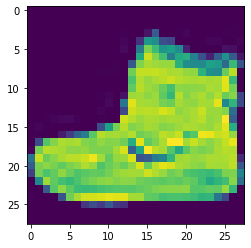

In [ ]:
# Visualize training data
i = 0
print(f"Sample {i} is number {y_train[i]}")
plt.imshow(x_train[0])

image = wandb.Image(x_train[0], caption=f"Training sample {i} is a {y_train[i]}")
wandb.log({"Example training image": image})

In [ ]:
# Log the datasets minimum and maximum intensities and datatype to the WandB summary
min_value = min(x_train.min(), x_test.min())
max_value = max(x_train.max(), x_test.max())
wandb_run.summary["raw"] = {"min": min_value, "max": max_value, "dtype": str(x_train.dtype)}

# Create a new histogram of the image pixels intensities
bin_names, train_hist = create_histogram(x_train)
log_bar(bin_names, train_hist, "Raw training data", x_name="bin", y_name="# pixels", keep_order=True)

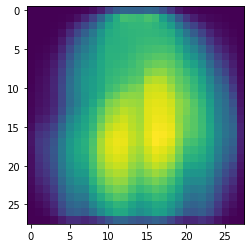

In [ ]:
# Create a heatmap over all active pixels from all frames
heatmap = np.mean(x_train, axis=0)
plt.imshow(heatmap)
wandb.log({"Heatmap of training images": wandb.Image(np.expand_dims(heatmap, axis=2), caption="The mean of all images in the training set")})

# Log a histogram of the average value for each pixel through out the
# training dataset. This shows us how many of the pixels that are
# always zero in all frames.
bin_names, heatmap_hist = create_histogram(heatmap.flatten(), bins=[0, 1, 10, 30, 100, 255])
log_bar(bin_names, heatmap_hist, "Average value per pixel in training data", x_name="bin", y_name="# pixels", keep_order=True)

In [ ]:
# Preprocess the data
# Normalize the values to the range -1...1
x_train_norm = x_train / 128 - 1
x_test_norm = x_test / 128 - 1

In [ ]:
# Create a new histogram of the modified values
min_value = min(x_train_norm.min(), x_test_norm.min())
max_value = max(x_train_norm.max(), x_test_norm.max())
wandb_run.summary["preprocessed"] = {"min": min_value, "max": max_value, "dtype": str(x_train_norm.dtype)}

bin_names, train_hist = create_histogram(x_train_norm)
log_bar(bin_names, train_hist, "Preprocessed training data", x_name="bin", y_name="# pixels", keep_order=True)

Sample 0 is number 9


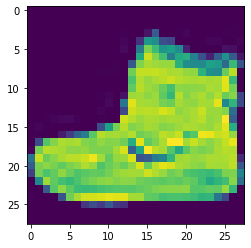

In [ ]:
i = 0
print(f"Sample {i} is number {y_train[i]}")
plt.imshow(x_train_norm[0])

image = wandb.Image(x_train_norm[0], caption=f"Training sample {i} is a {y_train[i]}")
wandb.log({"Example training image (preprocessed)": image})

In [ ]:
# Sample test data
num_images_per_label = Counter(y_test)
min_number_of_labels = min(num_images_per_label.values())

indexes_to_keep = []
for label in num_images_per_label.keys():
  indexes_to_keep.extend(
      np.random.choice(
          np.where(y_test == label)[0],
          size=min_number_of_labels,
          replace=False
      ).tolist()
  )

np.random.shuffle(indexes_to_keep)
x_test_norm_subsamp = x_test_norm[indexes_to_keep]
y_test_subsamp = y_test[indexes_to_keep]

In [ ]:
x_test_norm_subsamp.shape

(10000, 28, 28)

This should be a 9


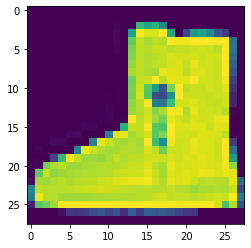

In [ ]:
# Verify that the labels and images are still in sync
print(f"This should be a {y_test_subsamp[0]}")
plt.imshow(x_test_norm_subsamp[0])

In [ ]:
# Log the new distribution
num_images_per_label = Counter(y_test_subsamp)
labels_, num_images = zip(*((str(label), number) for label, number in sorted(num_images_per_label.items())))
log_bar(labels_, num_images, "Labels in test data (subsampled)", x_name="Label", y_name="# images")